In [161]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
import random
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

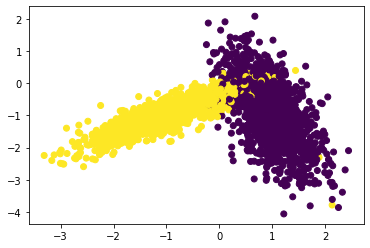

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

#step1
creates a random list of 10 unique integers in given range

#step2
Divides the indieces list into fractions of number of folds given and stores in split list. Each element is a group.
#step3
For each fold we make the split[ i ] as the cv group and using sets we make remaining indices as train group.

Rest of the code is same as reference

In [179]:
def rand_searchcv(x_train,y_train,classifier,param_range,folds):
  #step 1
  low, high = param_range
  params = sorted(random.sample(range(low,high+1),10))
  
  #step2
  lis_indices = list(range(len(x_train)))

  split = []
  for i in range(folds):
    split.append(lis_indices[i*int(len(lis_indices)/folds): (i+1)*int(len(lis_indices)/folds)])
  
  trainscores = []
  testscores  = []
  #step3
  for k in tqdm(params):
    trainscores_folds = []
    testscores_folds  = []

    for j in range(folds):
      train_ind = list(set(lis_indices)- set(split[j]))
      test_ind  = split[j]

      X_train = x_train[train_ind]
      Y_train = y_train[train_ind]
      X_test  = x_train[test_ind]
      Y_test =  y_train[test_ind]

      classifier.n_neighbors = k
      classifier.fit(X_train,Y_train)

      Y_predicted = classifier.predict(X_test)
      testscores_folds.append(accuracy_score(Y_test,Y_predicted))

      Y_predicted = classifier.predict(X_train)
      trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
    trainscores.append(np.mean(np.array(trainscores_folds)))
    testscores.append(np.mean(np.array(testscores_folds)))
  
  #step4
  return trainscores, testscores, params

In [180]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
param_range = (1,50)
folds = 3

In [181]:
#step5
trainscores, cvscores,params =rand_searchcv(X_train,y_train,classifier,param_range, folds)

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


In [182]:
params

[12, 13, 14, 18, 19, 20, 31, 34, 38, 49]

<function matplotlib.pyplot.show(*args, **kw)>

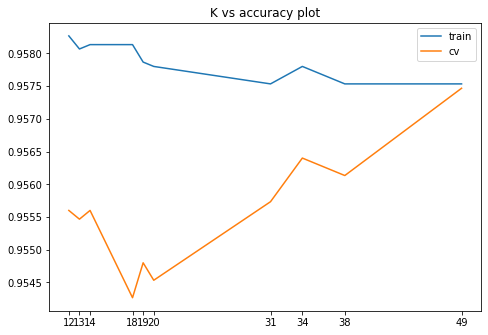

In [184]:
#step6
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_xticks(params)

plt.plot(params,trainscores,label ="train")
plt.plot(params,cvscores,label = 'cv')
plt.title('K vs accuracy plot')
plt.legend()
plt.show

**K = 49 is the best k according to the figure**

In [185]:
#step7
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

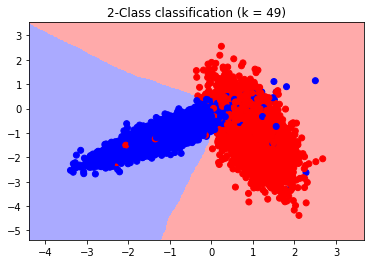

In [186]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 49)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)